# Batched SQP: Hyperparameter Sweep and Convergence

This notebook evaluates batched SQP convergence by sweeping per-batch `rho` and global cost weights (`q_cost`, `qd_cost`, `u_cost`).
It plots the average, normalized best-merit per iteration across 100 random targets for multiple batch sizes and a single-solve adaptive-ρ baseline.

In [71]:
import os, sys, numpy as np, matplotlib.pyplot as plt
import pickle
sys.path.append('python')
from bsqp.interface import BSQP
np.set_printoptions(precision=3, linewidth=160)


plt.rcParams['font.size'] = 12
plt.rcParams["font.family"] = "serif"
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 16

# Color palette
color_palette = {
    'B=1 (1e-1)': '#003192',  # rho=1e-1
    'B=1 (1e-3)': '#56B4E9',  # rho=1e-3
    'B=2': '#8B4513',         # brown
    'B=4': '#747474',
    'B=8': '#7030A0',
    'B=16': '#F19759',
    'B=32': '#00693E',
    'B=128': '#FF6600',       # orange for B=128 (appears in later cells)
    'Adaptive (B=1)': '#000000'  # black for adaptive baseline
}


In [117]:
def build_solver(batch_size, q_cost, qd_cost, u_cost, N_cost, *, adapt_rho, rho_batch=None, rho=1e-3):
    return BSQP(
        model_path=model_path, batch_size=batch_size, N=N, dt=dt,
        max_sqp_iters=MAX_ITERS, kkt_tol=0.0, max_pcg_iters=MAX_PCG_ITERS, pcg_tol=PCG_TOL, solve_ratio=1.0,
        mu=MU, q_cost=q_cost, qd_cost=qd_cost, u_cost=u_cost, N_cost=N_cost,
        q_lim_cost=Q_LIM_COST, vel_lim_cost=VEL_LIM_COST, ctrl_lim_cost=CTRL_LIM_COST,
        rho=rho, rho_batch=rho_batch, adapt_rho=adapt_rho
    )

def sample_goal():
    x = np.random.uniform(-0.8, 0.8)
    y = np.random.uniform(-0.8, 0.8)
    z = np.random.uniform(0.2, 0.8)
    return np.array([x, y, z, 0.0, 0.0, 0.0], dtype=np.float32)

def _best_curve_from_stats(stats):
    best = stats.get('best_merit_per_iter', None)
    if best is None:
        ls = np.asarray(stats.get('min_merit', None))
        if ls is None:
            raise RuntimeError('min_merit not found in stats')
        if ls.ndim == 2:
            best = np.min(ls, axis=1)
        elif ls.ndim == 1:
            best = ls
        else:
            raise RuntimeError(f'Unexpected min_merit ndim={ls.ndim}, shape={ls.shape}')
    return np.asarray(best, dtype=np.float32).reshape(-1)

def get_best_curve_for_B(B, q_cost, qd_cost, u_cost, N_cost, ee_goal6):
    fractions = np.arange(1, B+1) / (B + 1)  # [1/(B+1), 2/(B+1), ..., B/(B+1)]
    rho_vals = [RHO_MIN_EXP + f * (RHO_MAX_EXP - RHO_MIN_EXP) for f in fractions]
    rho_vals = np.power(10, rho_vals).astype(np.float32)
    solver = build_solver(B, q_cost, qd_cost, u_cost, N_cost, adapt_rho=False, rho_batch=rho_vals)
    nx = solver.nx; nu = solver.nu
    x0 = np.zeros(nx, dtype=np.float32)
    x0_B = np.tile(x0, (B, 1))
    ref_traj_one = np.tile(ee_goal6, N).astype(np.float32)
    ref_B = np.tile(ref_traj_one, (B, 1))
    XU_B = np.zeros((B, solver.N * (nx + nu) - nu), dtype=np.float32)
    XU_B[:, :nx] = x0_B
    solver.solve(x0_B, ref_B, XU_B)
    stats = solver.get_stats()
    denom = float(stats.get('best_initial_merit', np.nan))
    curve = _best_curve_from_stats(stats)
    curve = curve / denom if (denom and denom==denom and denom!=0) else curve
    return np.r_[1.0, curve]

def get_best_curve_adaptive(q_cost, qd_cost, u_cost, N_cost, ee_goal6, rho):
    solver = build_solver(1, q_cost, qd_cost, u_cost, N_cost, adapt_rho=True, rho_batch=None, rho=rho)
    nx = solver.nx; nu = solver.nu
    x0 = np.zeros(nx, dtype=np.float32)
    x1 = x0.reshape(1,-1)
    ref_traj_one = np.tile(ee_goal6, N).astype(np.float32)
    ee1 = ref_traj_one.reshape(1,-1)
    XU_B = np.zeros((1, solver.N * (nx + nu) - nu), dtype=np.float32)
    XU_B[:, :nx] = x1
    solver.solve(x1, ee1, XU_B)
    stats = solver.get_stats()
    denom = float(stats.get('best_initial_merit', np.nan))
    curve = _best_curve_from_stats(stats)
    curve = curve / denom if (denom and denom==denom and denom!=0) else curve
    return np.r_[1.0, curve]

def run_config(q_cost, qd_cost, u_cost, N_cost):
    # Collect normalized curves per label across NUM_TARGETS
    per_label_curves = {**{f'B={B}': [] for B in B_list}, 'B=1 (1e-1)': [], 'B=1 (1e-3)': []}
    for _ in range(NUM_TARGETS):
        goal = sample_goal()
        raw = {}  # label -> raw best curve (no normalization yet)
        for B in B_list:
            try:
                raw[f'B={B}'] = get_best_curve_for_B(B, q_cost, qd_cost, u_cost, N_cost, goal)
            except Exception as e:
                print(f'Skipping B={B}: {e}')
        try:
            raw['B=1 (1e-1)'] = get_best_curve_adaptive(q_cost, qd_cost, u_cost, N_cost, goal, rho=1e-1)
            raw['B=1 (1e-3)'] = get_best_curve_adaptive(q_cost, qd_cost, u_cost, N_cost, goal, rho=1e-3)
        except Exception as e:
            print(f'Skipping adaptive baseline: {e}')
        # Normalize all iterations by the WORST 'best-merit' at iter 1 across labels (scalar)
        valid_curves = [v for v in raw.values() if v is not None and len(v) > 0]
        if not valid_curves:
            continue
        Kmin = min(len(v) for v in valid_curves)
        stack = np.vstack([v[:Kmin] for v in valid_curves])
        first_iter_vals = stack[:, 0]
        denom = float(np.max(first_iter_vals))
        if denom == 0.0: denom = 1.0
        for label, curve in raw.items():
            if curve is None or len(curve) == 0:
                continue
            per_label_curves[label].append((curve[:Kmin] / denom).astype(np.float32))
    # Average normalized curves per label
    results = {}
    for label, curves in per_label_curves.items():
        if not curves:
            continue
        Kmin = min(len(c) for c in curves)
        M = np.vstack([c[:Kmin] for c in curves])
        results[label] = np.mean(M, axis=0)
    return results


In [126]:
# Hyperparameters (edit here)
model_path = 'iiwa_description/iiwa14.urdf'
N = 64                     # knots
dt = 0.05                  # time step [s]
B_list = [2, 4, 8, 16, 32]       # batch sizes to compare
NUM_TARGETS = 100          # number of random target points
MAX_ITERS = 50            # SQP iterations
MAX_PCG_ITERS = 200
PCG_TOL = 1e-3
MU = 1.0
Q_LIM_COST = 0.0
VEL_LIM_COST = 0.0
CTRL_LIM_COST = 0.0
# Rho sweep (batched per iteration)
RHO_MIN_EXP = -5
RHO_MAX_EXP = 1
# Global cost sweep (each combo is a separate experiment)
Q_LIST = [10.0, 5.0, 1.0]            # state cost
QD_LIST = [1e-1, 1e-3, 1e-5]         # velocity cost
U_LIST = [1e-5, 1e-6, 1e-7]          # control cost
N_LIST = [100.0, 50, 10.0]
# Reproducibility
SEED = 0
np.random.seed(SEED)


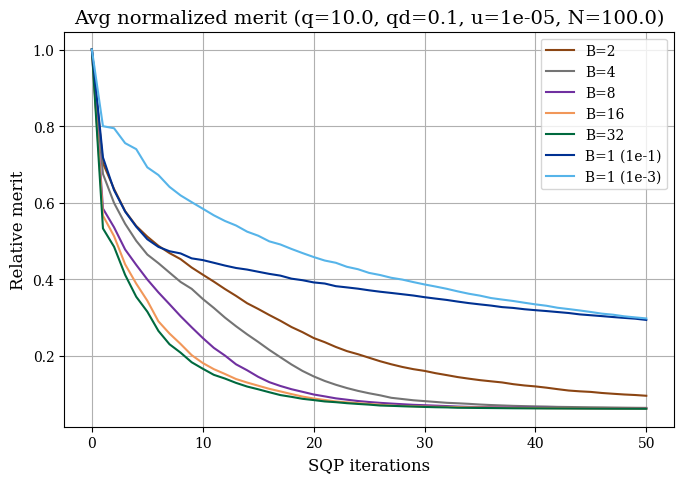

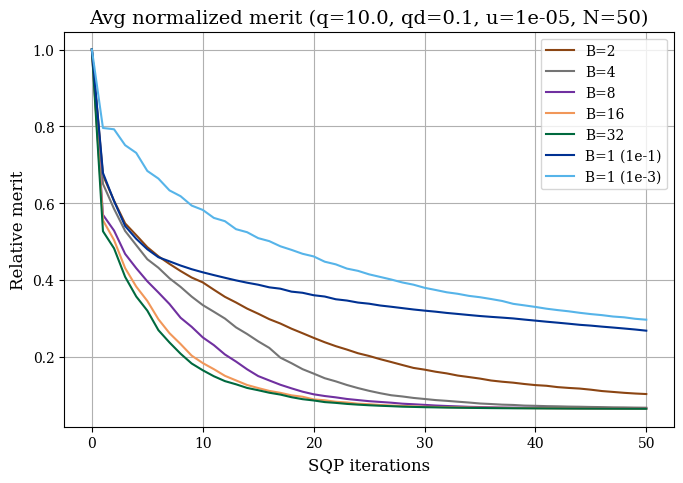

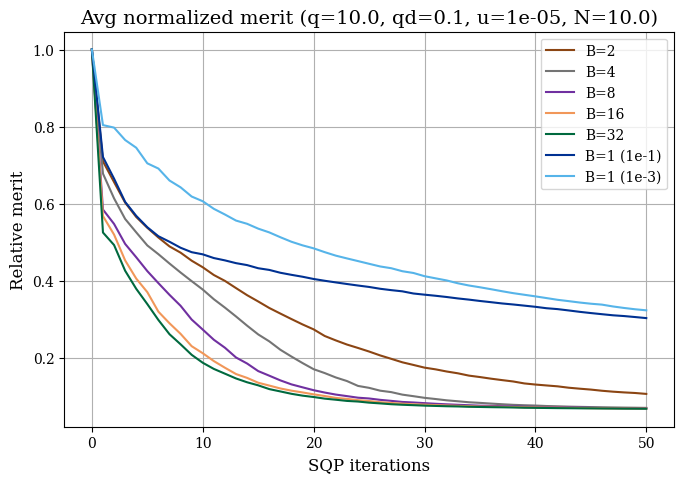

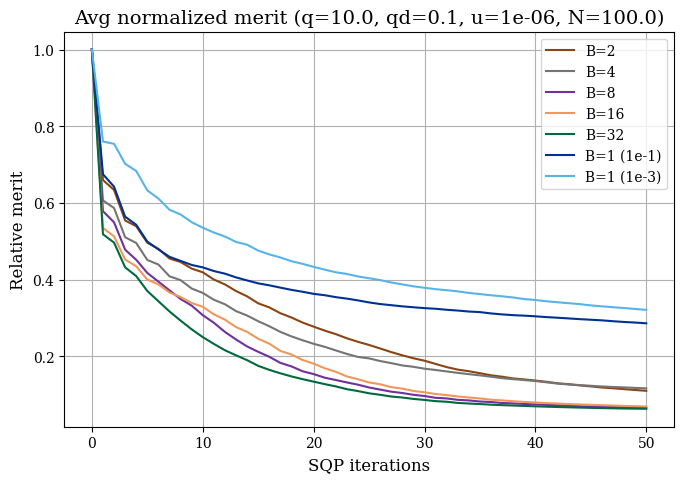

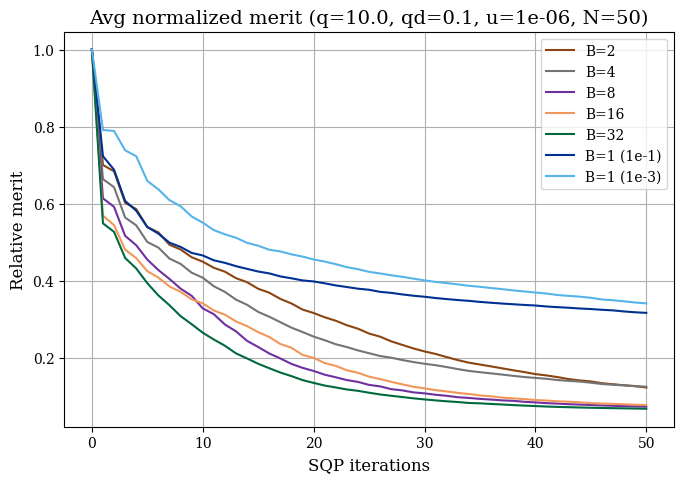

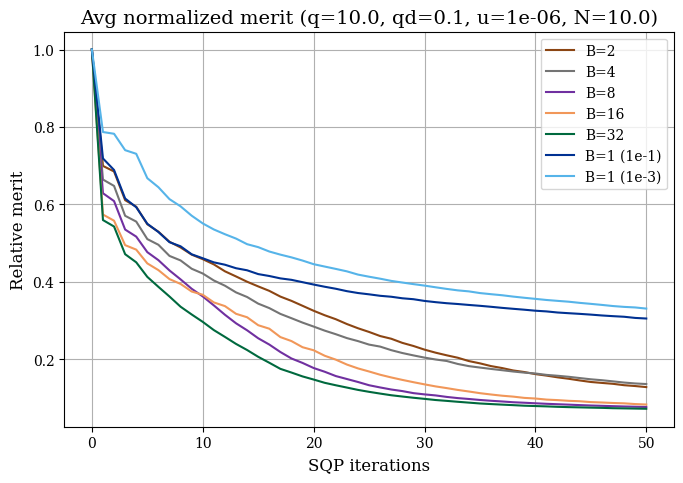

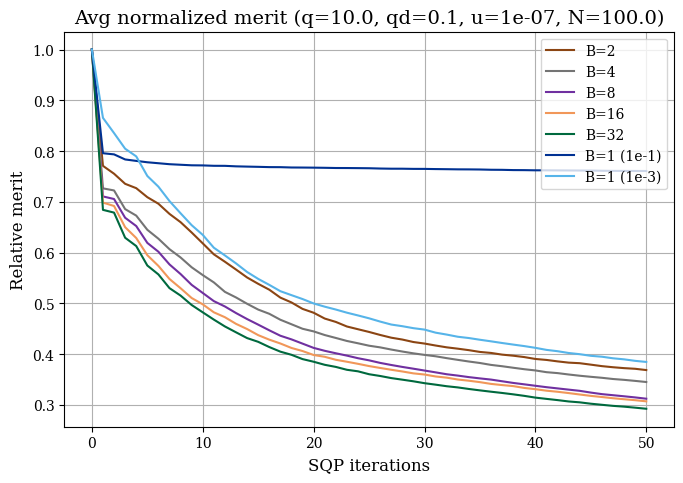

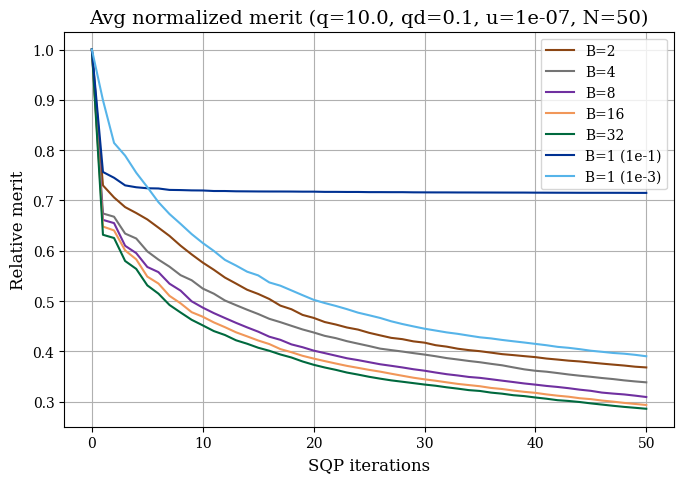

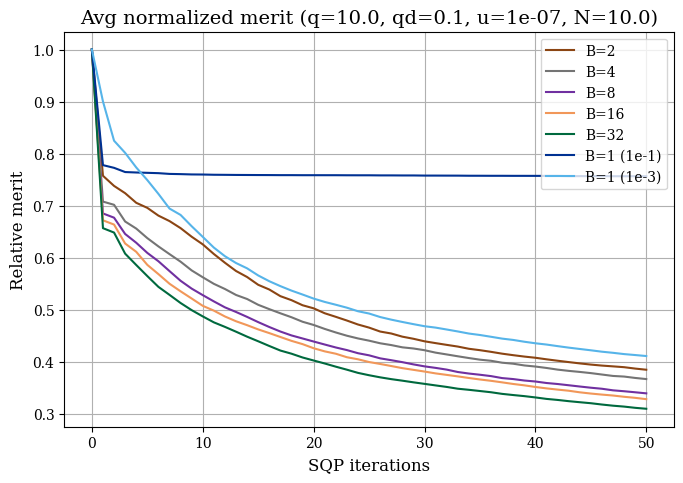

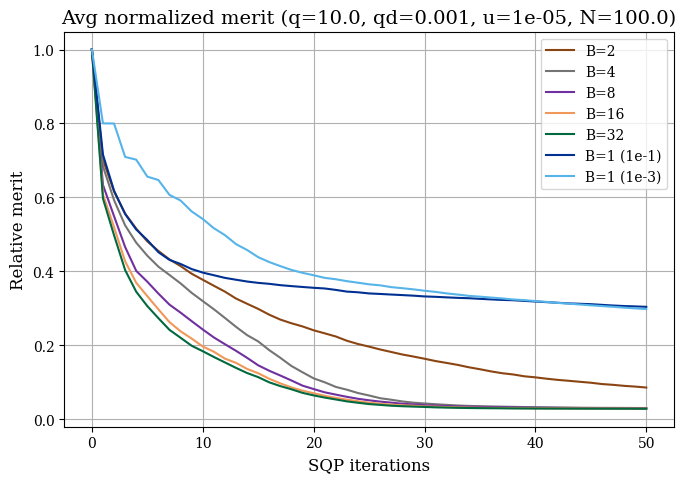

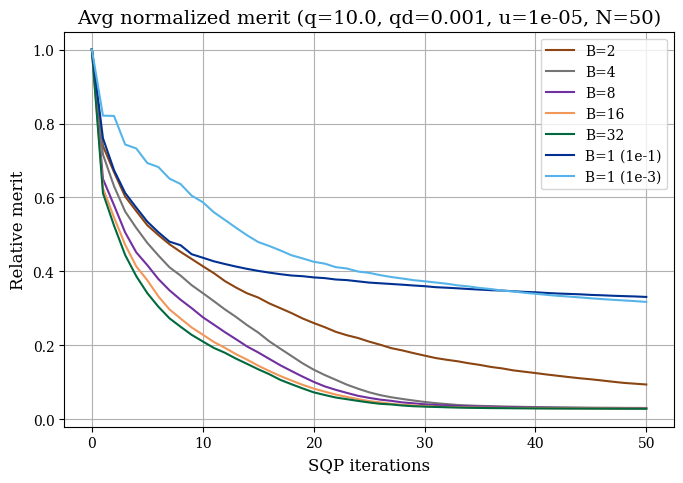

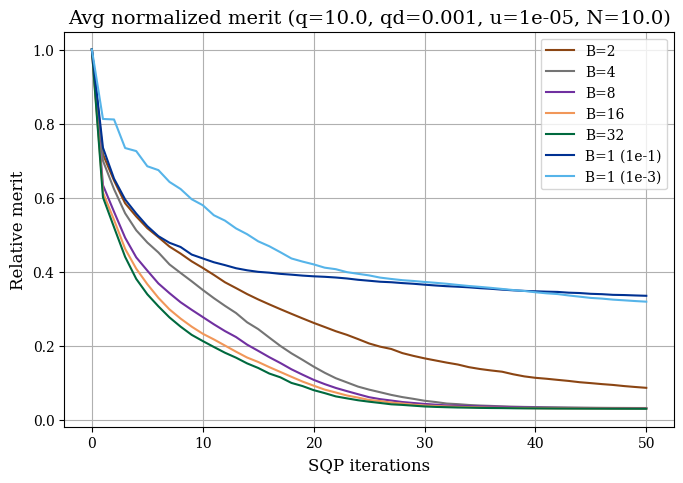

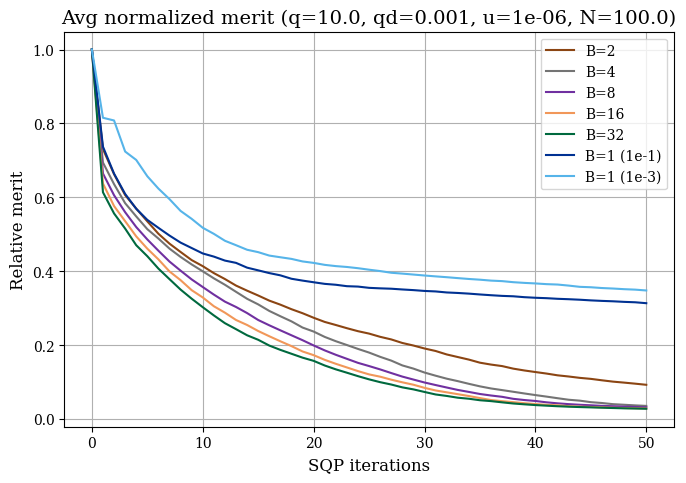

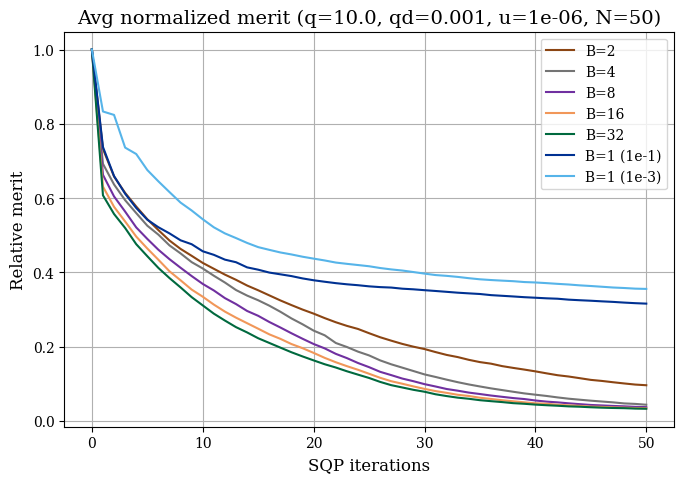

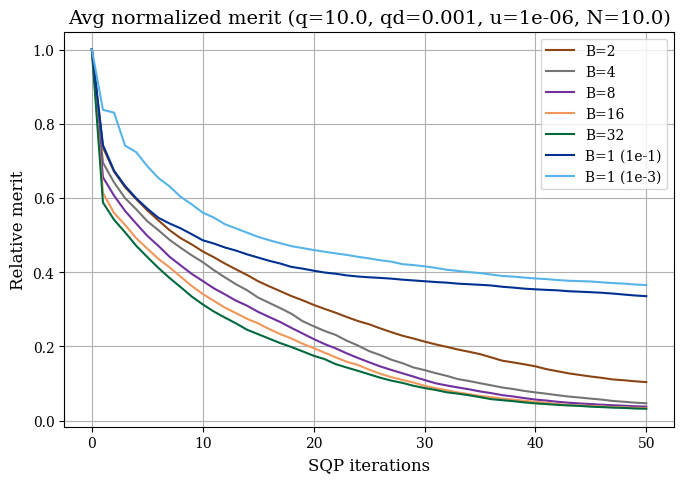

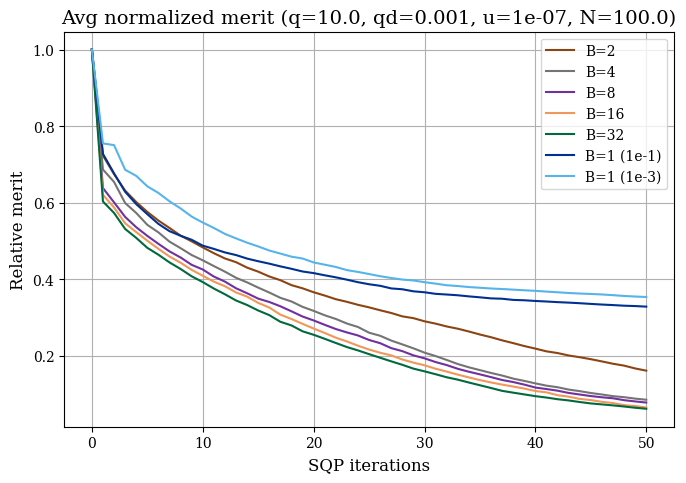

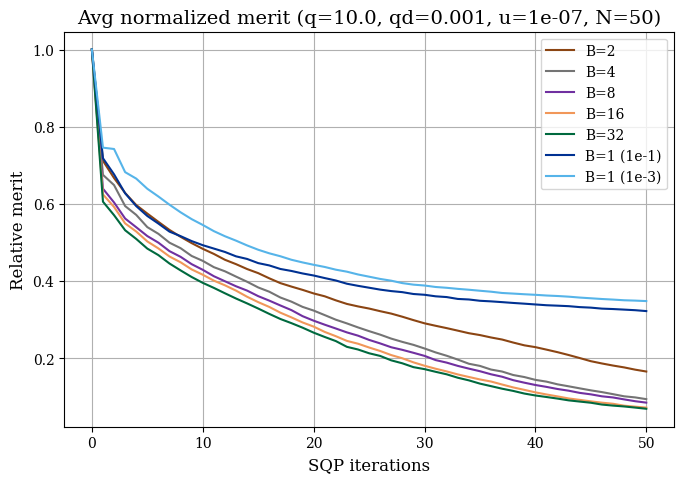

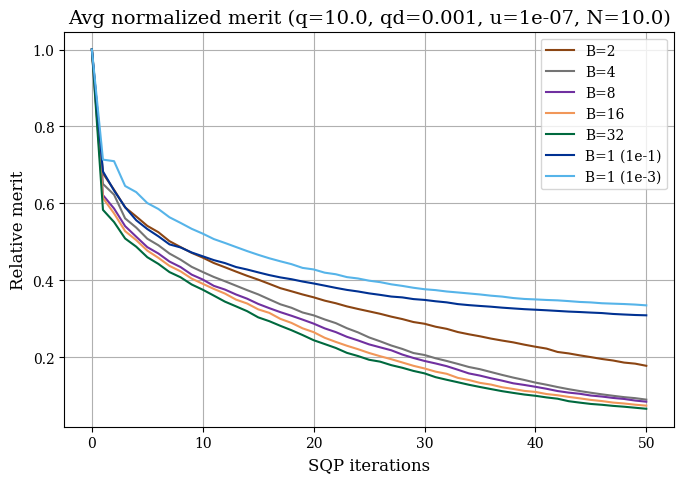

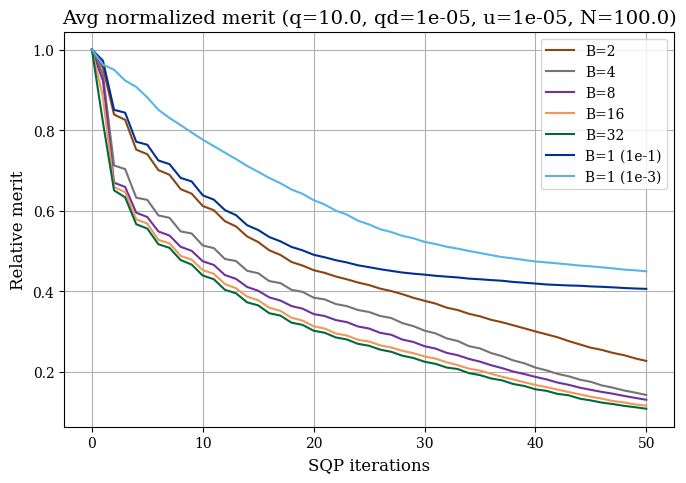

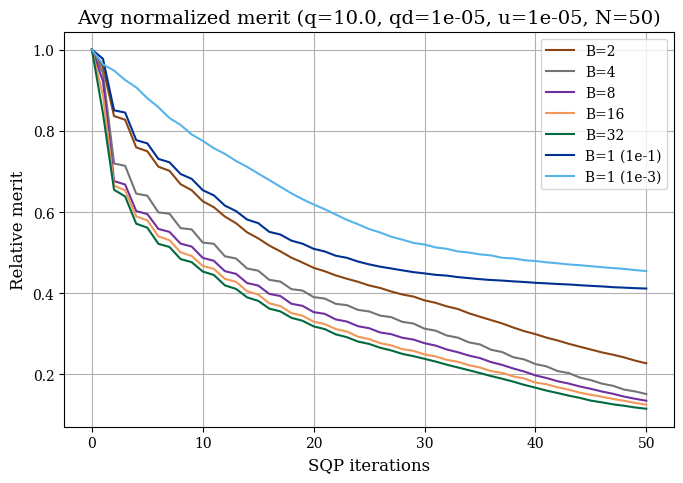

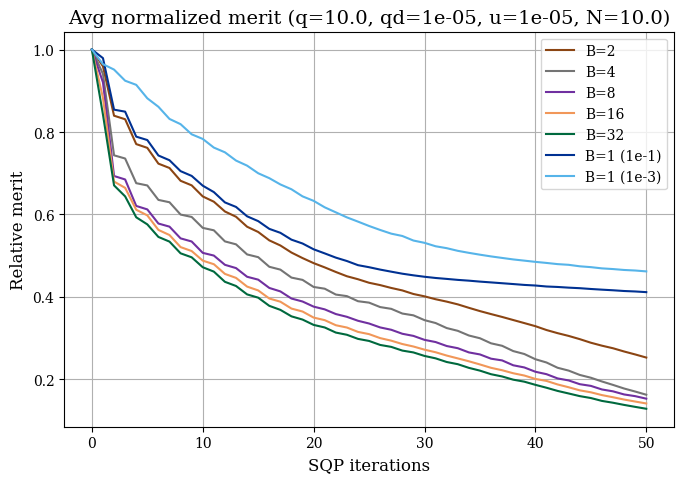

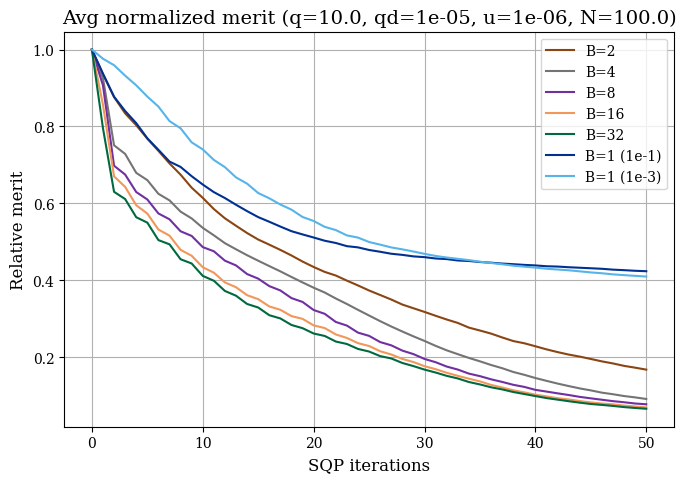

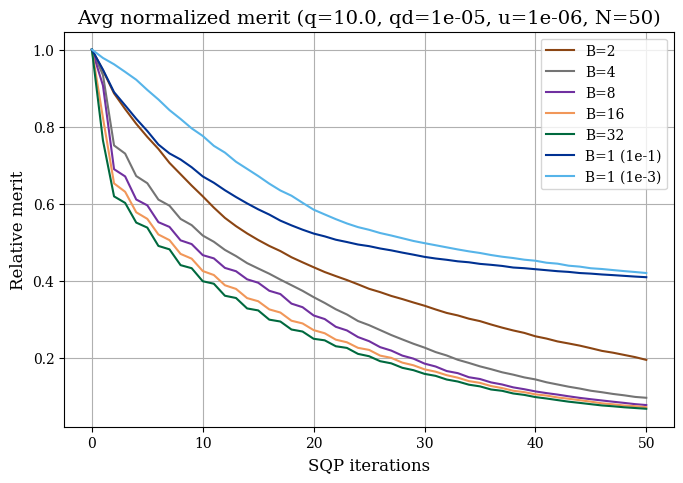

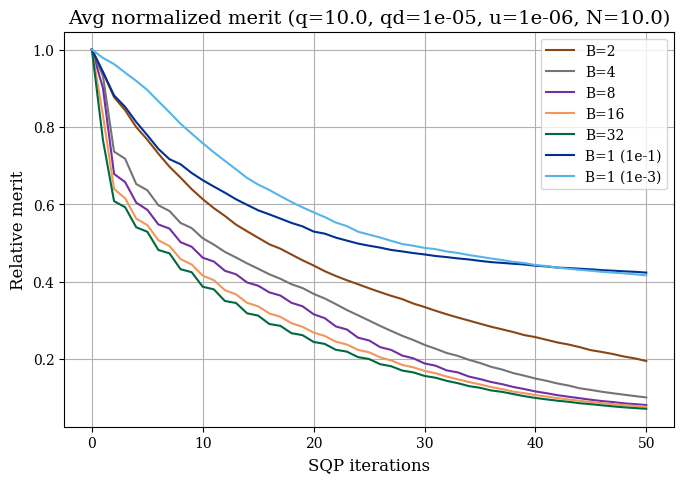

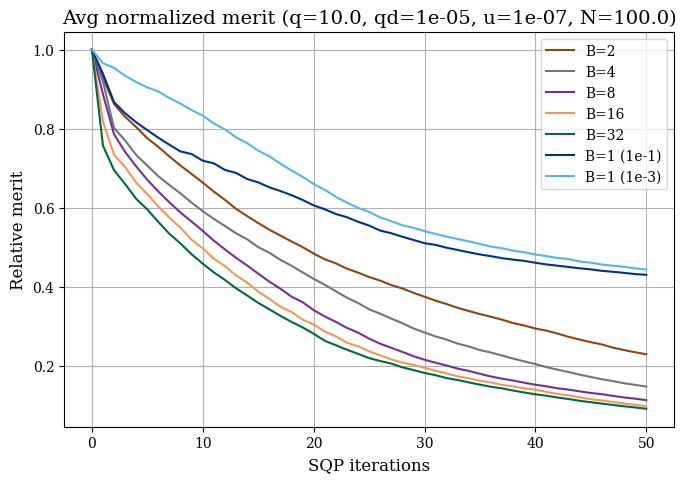

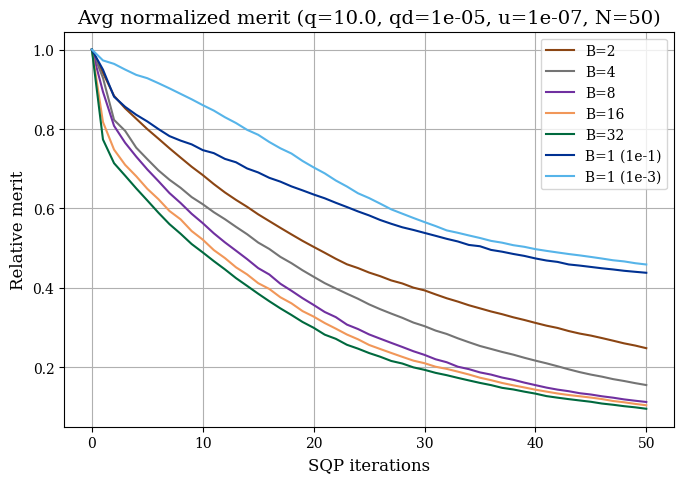

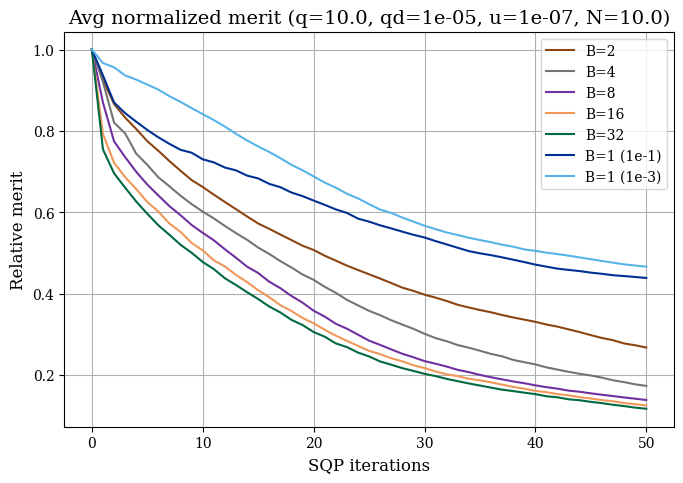

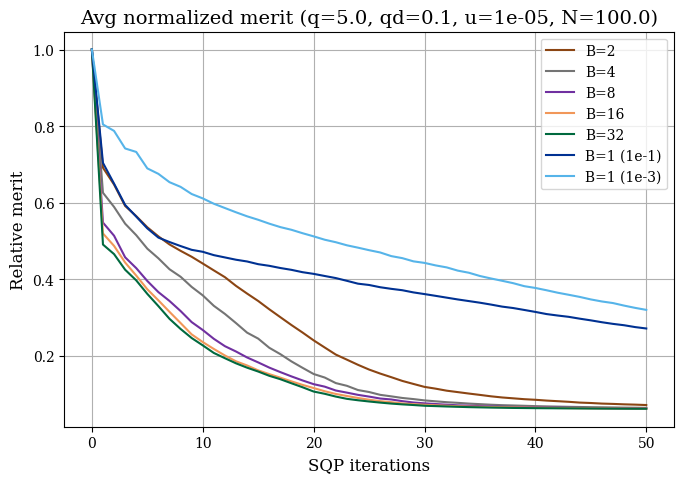

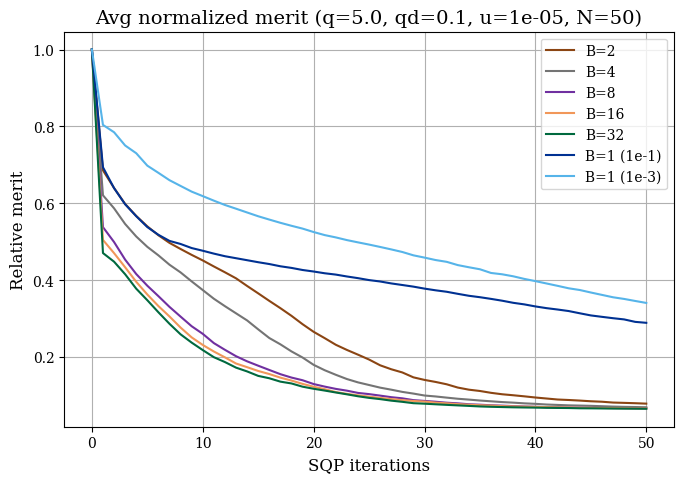

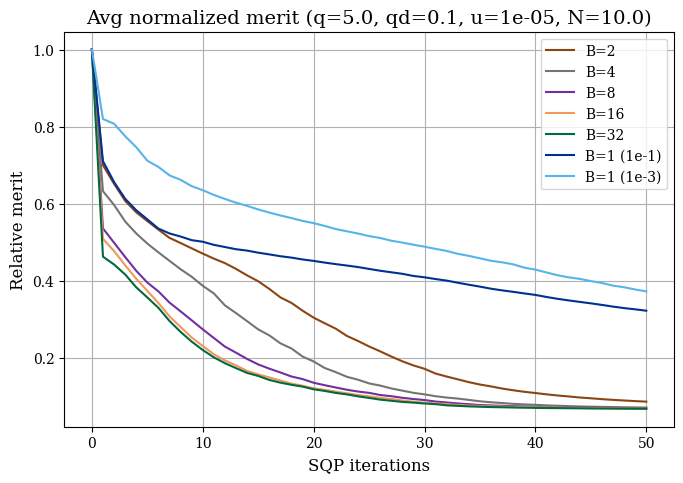

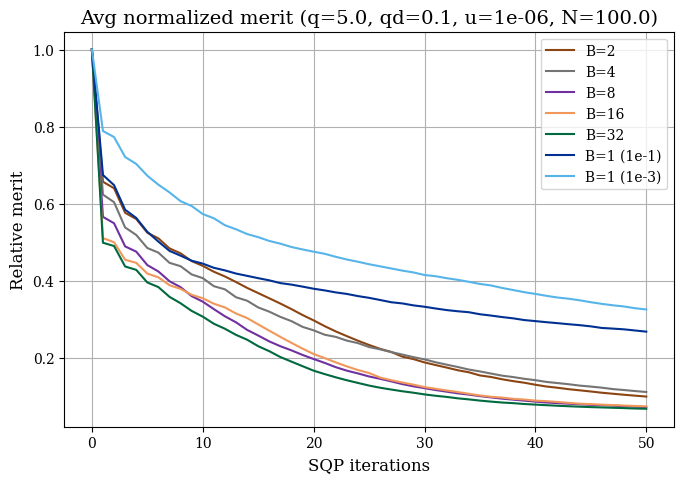

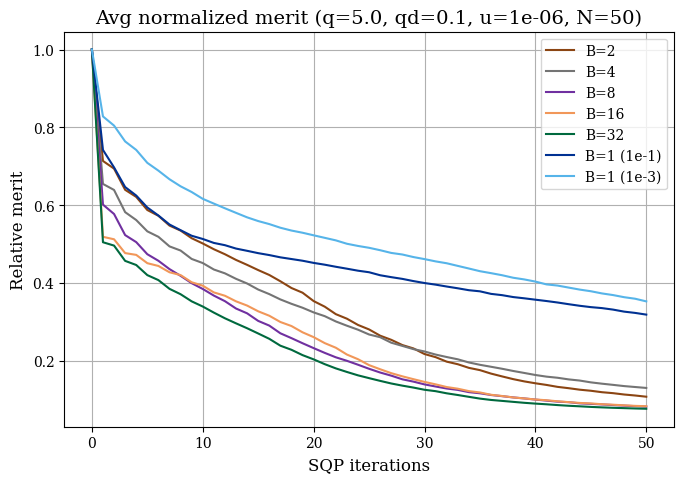

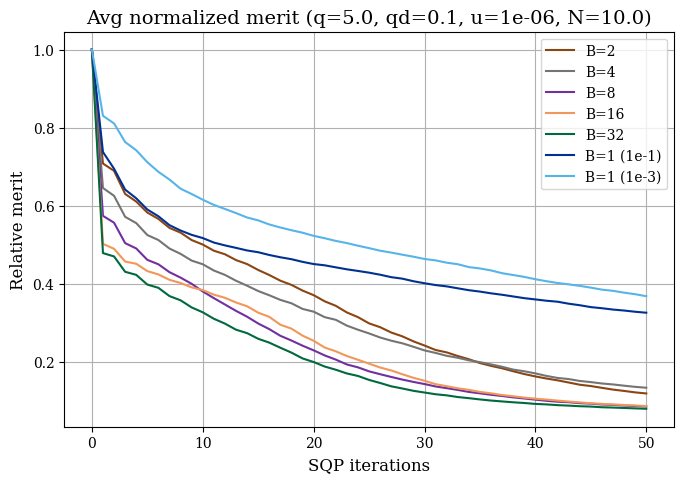

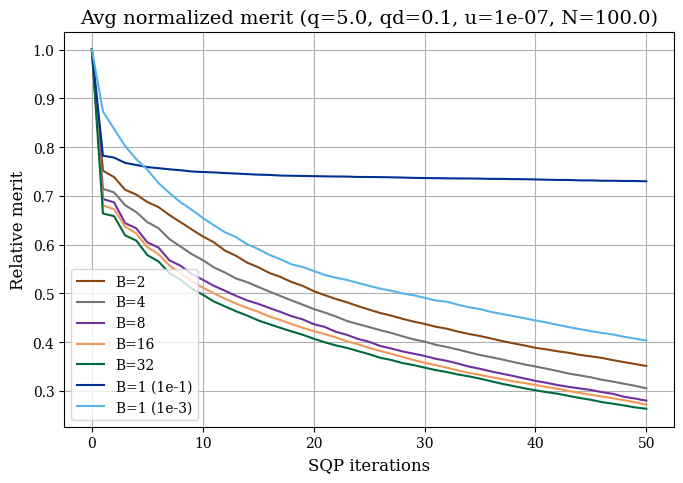

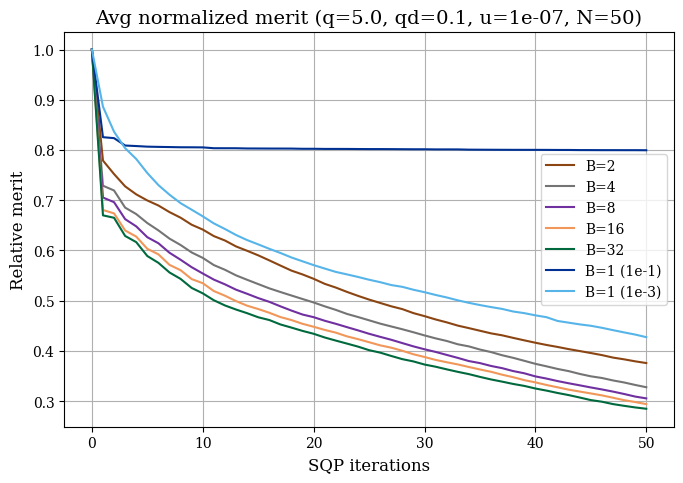

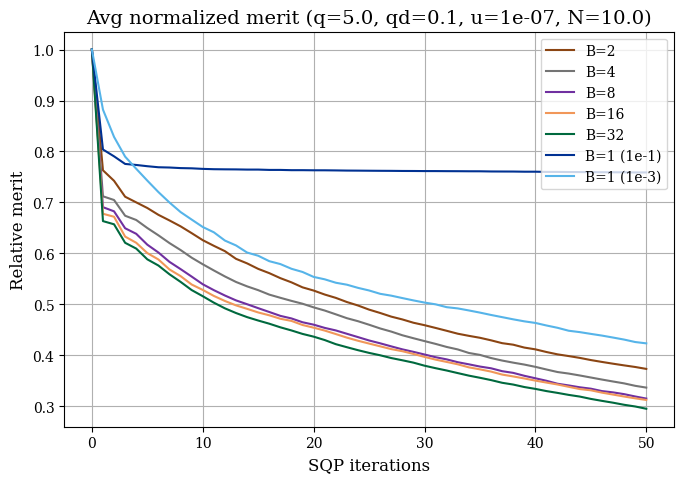

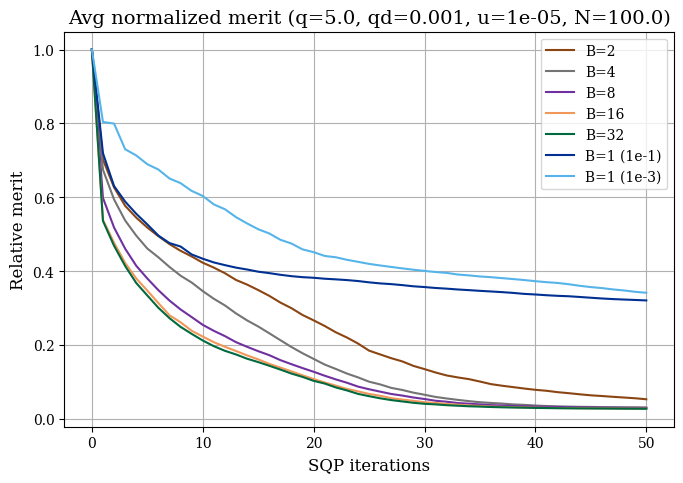

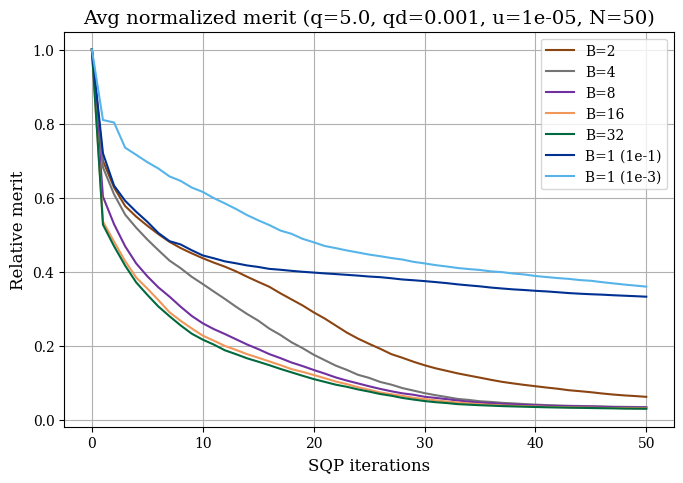

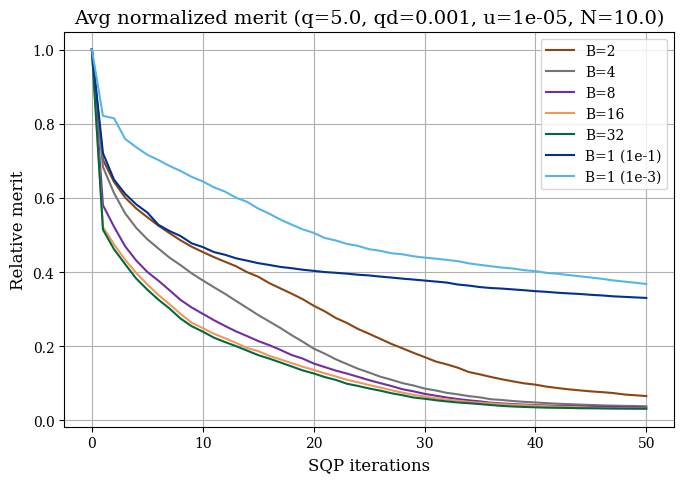

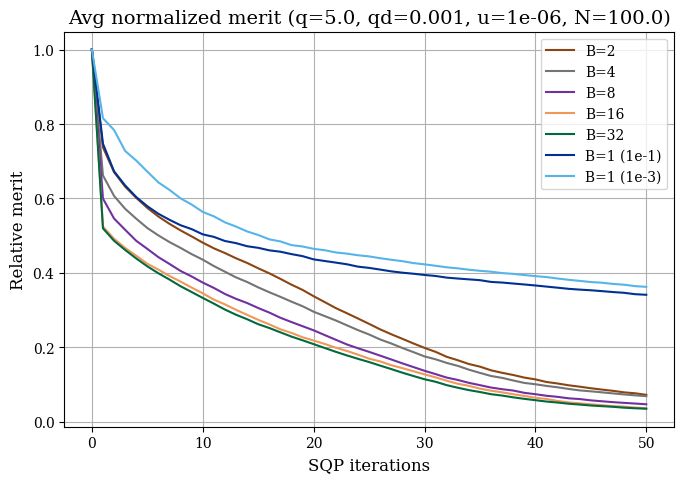

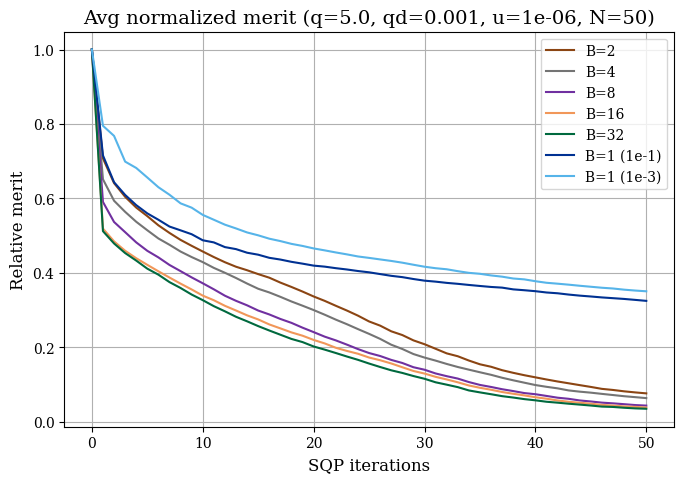

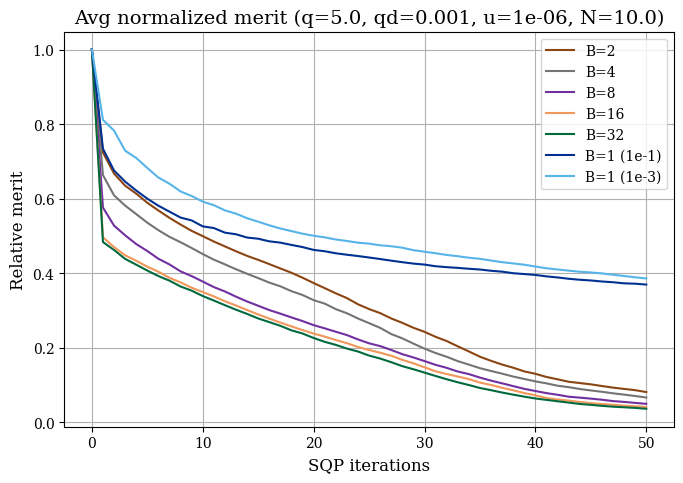

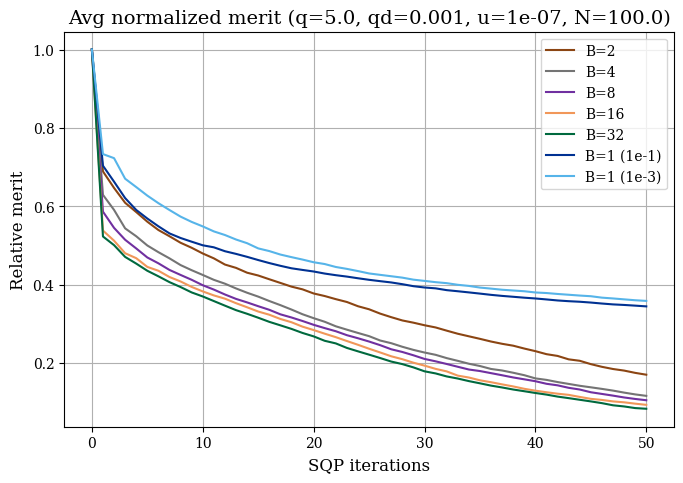

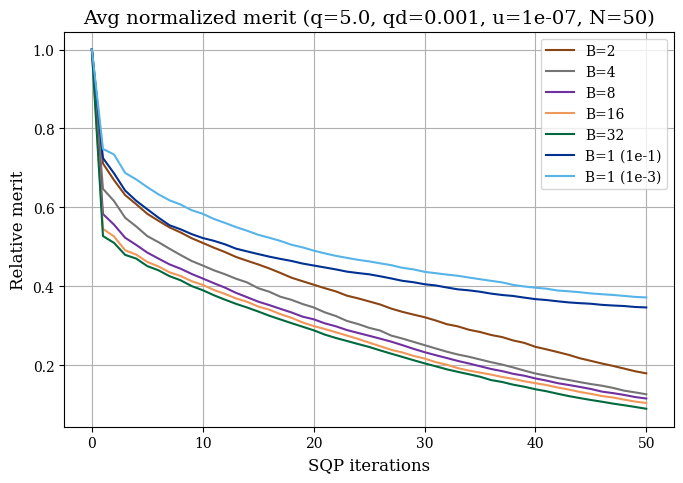

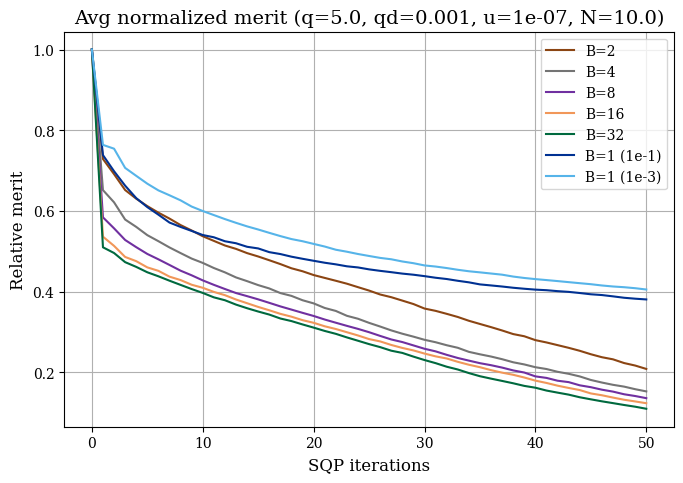

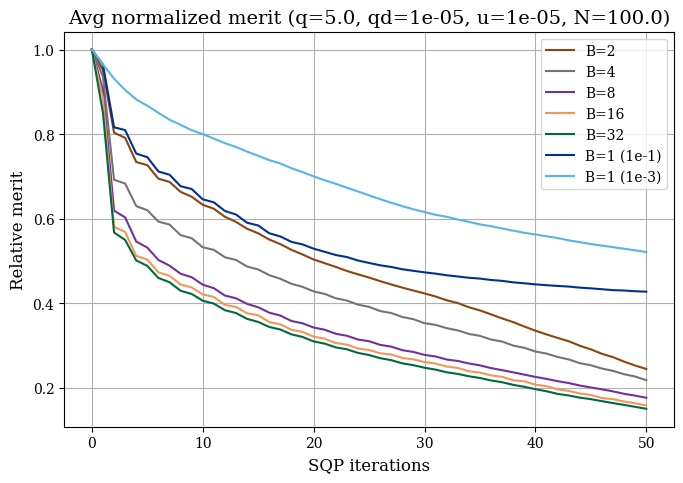

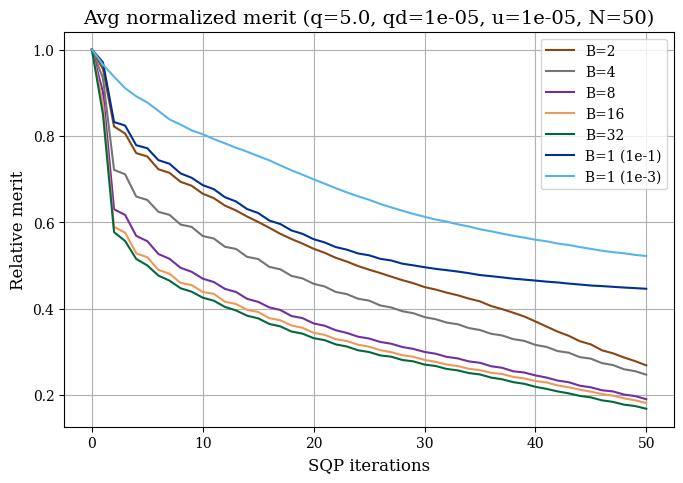

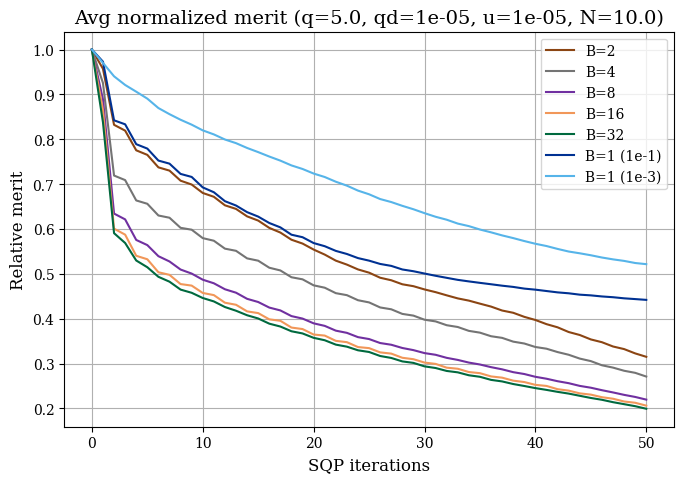

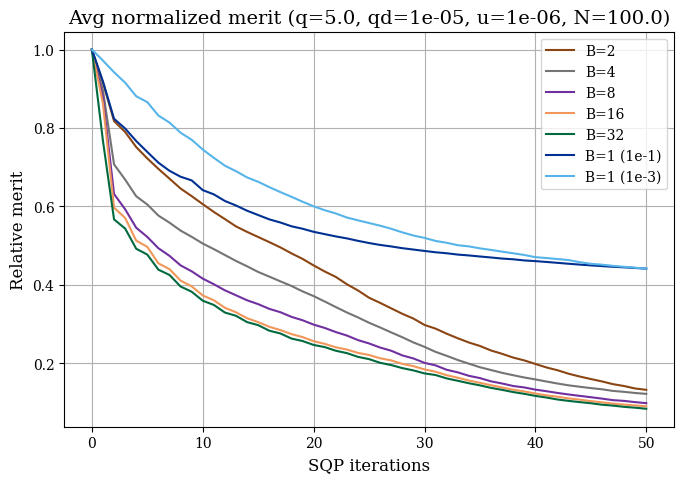

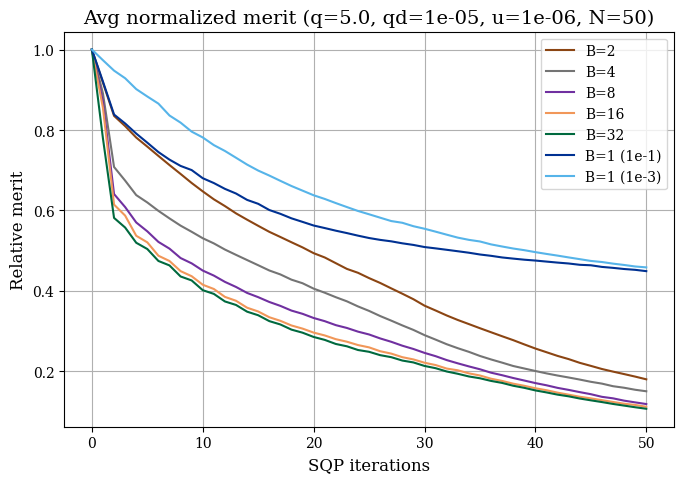

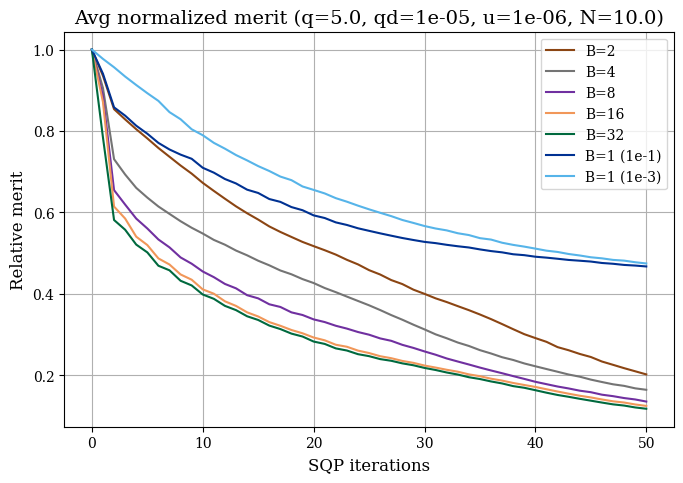

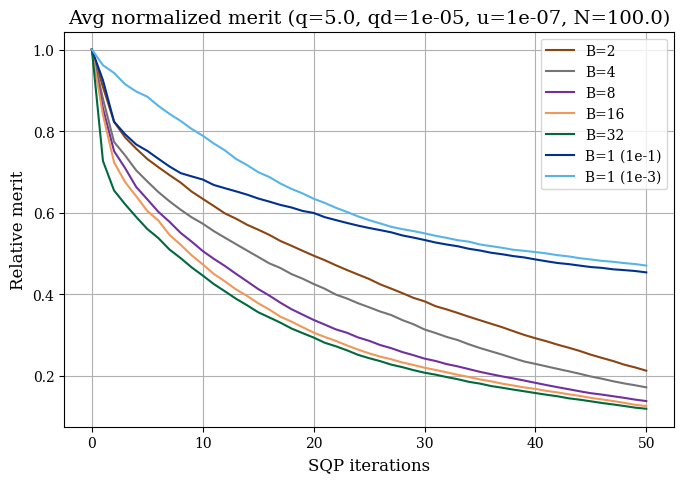

In [ ]:
# Aggregate across all runs and also plot per-cost figures
# Check if we have saved results
RESULTS_FILE = 'gato_hparam_batch_results.pkl'
LOAD_FROM_FILE = False  # Set to True to skip experiments and load from file

if LOAD_FROM_FILE and os.path.exists(RESULTS_FILE):
    print(f"Loading results from {RESULTS_FILE}")
    with open(RESULTS_FILE, 'rb') as f:
        agg = pickle.load(f)
else:
    agg = {}  # label -> list of avg normalized curves per cost-config
    for q_cost in Q_LIST:
        for qd_cost in QD_LIST:
            for u_cost in U_LIST:
                for N_cost in N_LIST:
                    results = run_config(q_cost, qd_cost, u_cost, N_cost)
                    # Accumulate for final aggregation
                    for label, avg_curve in results.items():
                        agg.setdefault(label, []).append(avg_curve)
                    # Per-cost plot
                    plt.figure(figsize=(7,5))
                    for label, avg_curve in results.items():
                        color = color_palette.get(label, None)
                        plt.plot(np.arange(len(avg_curve)), avg_curve, label=label, color=color)
                    plt.xlabel('SQP iterations')
                    plt.ylabel('Relative merit')
                    plt.title(f'Avg normalized merit (q={q_cost}, qd={qd_cost}, u={u_cost}, N={N_cost})')
                    plt.grid(True)
                    plt.legend()
                    plt.tight_layout()
                    plt.show()
    
    # Save results to pickle file
    print(f"Saving results to {RESULTS_FILE}")
    with open(RESULTS_FILE, 'wb') as f:
        pickle.dump(agg, f)

# Final aggregated plot across all runs
final_avg = {}
for label, curves in agg.items():
    if not curves:
        continue
    Kmin = min(len(c) for c in curves)
    M = np.vstack([c[:Kmin] for c in curves])
    final_avg[label] = np.mean(M, axis=0)
# Use common length across labels for plotting
if final_avg:
    Kcommon = min(len(v) for v in final_avg.values())
    plt.figure(figsize=(8,5))
    for label, curve in final_avg.items():
        color = color_palette.get(label, None)
        plt.plot(np.arange(0, Kcommon), curve[:Kcommon], label=label, color=color)
    plt.xlabel('SQP iterations')
    plt.ylabel('Relative merit')
    plt.title('')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
# Load and plot from saved results (without rerunning experiments)
RESULTS_FILE = 'gato_hparam_batch_results.pkl'

if os.path.exists(RESULTS_FILE):
    print(f"Loading results from {RESULTS_FILE}")
    with open(RESULTS_FILE, 'rb') as f:
        agg = pickle.load(f)
    
    # Create final aggregated plot
    final_avg = {}
    for label, curves in agg.items():
        if not curves:
            continue
        Kmin = min(len(c) for c in curves)
        M = np.vstack([c[:Kmin] for c in curves])
        final_avg[label] = np.mean(M, axis=0)
    
    # Plot
    if final_avg:
        Kcommon = min(len(v) for v in final_avg.values())
        plt.figure(figsize=(8,5))
        for label, curve in final_avg.items():
            color = color_palette.get(label, None)
            plt.plot(np.arange(0, Kcommon), curve[:Kcommon], label=label, color=color)
        plt.xlabel('SQP iterations')
        plt.ylabel('Relative merit')
        plt.title('Loaded from saved results')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()
else:
    print(f"No saved results found at {RESULTS_FILE}. Run the experiments first.")


In [ ]:
## Batch Size vs SQP Convergence (Avg over 100 targets)
np.random.seed(0)
B_list = [8, 32, 128]

def sample_goal():
    x = np.random.uniform(0.2, 1.0)
    y = np.random.uniform(0.2, 1.0)
    z = np.random.uniform(0.2, 0.7)
    return np.array([x, y, z, 0.0, 0.0, 0.0], dtype=np.float32)

def _best_curve_from_stats(stats):
    best = stats.get('best_merit_per_iter', None)
    if best is None:
        ls = np.asarray(stats.get('min_merit', None))
        if ls is None:
            raise RuntimeError('min_merit not found in stats')
        if ls.ndim == 2:
            best = np.min(ls, axis=1)
        elif ls.ndim == 1:
            best = ls
        else:
            raise RuntimeError(f'Unexpected min_merit ndim={ls.ndim}, shape={ls.shape}')
    return np.asarray(best, dtype=np.float32).reshape(-1)

def get_best_curve_for_B(B, ee_goal6, max_iters=100):
    # Create uniformly distributed rho values in log space, excluding endpoints
    # For B values, we want them at positions 1/(B+1), 2/(B+1), ..., B/(B+1)
    log_min = -6  # np.log10(1e-6)
    log_max = 10  # np.log10(1e10)
    fractions = np.arange(1, B+1) / (B + 1)  # [1/(B+1), 2/(B+1), ..., B/(B+1)]
    log_vals = log_min + fractions * (log_max - log_min)
    rho_vals = np.power(10, log_vals).astype(np.float32)
    mu_vals = np.full(B, 10.0, dtype=np.float32)
    pcg_tol_vals = np.full(B, 1e-6, dtype=np.float32)
    solver = BSQP(
        model_path=model_path, batch_size=B, N=N, dt=dt,
        max_sqp_iters=max_iters, kkt_tol=0.0, max_pcg_iters=200, pcg_tol=1e-5, solve_ratio=1.0,
        mu=10.0, q_cost=2.0, qd_cost=2e-4, u_cost=2e-6, N_cost=50.0,
        q_lim_cost=0.0, vel_lim_cost=0.0, ctrl_lim_cost=0.0,
        rho=1e-3, rho_batch=rho_vals, mu_batch=mu_vals, pcg_tol_batch=pcg_tol_vals, adapt_rho=False
    )
    nx = solver.nx; nu = solver.nu
    x0 = np.zeros(nx, dtype=np.float32)
    x0_B = np.tile(x0, (B, 1))
    ref_traj_one = np.tile(ee_goal6, N).astype(np.float32)
    ref_B = np.tile(ref_traj_one, (B, 1))
    XU_B = np.zeros((B, solver.N * (nx + nu) - nu), dtype=np.float32)
    XU_B[:, :nx] = x0_B
    solver.solve(x0_B, ref_B, XU_B)
    stats = solver.get_stats()
    return _best_curve_from_stats(stats)

def get_best_curve_adaptive(ee_goal6, max_iters=100):
    solver = BSQP(
        model_path=model_path, batch_size=1, N=N, dt=dt,
        max_sqp_iters=max_iters, kkt_tol=0.0, max_pcg_iters=100, pcg_tol=1e-4, solve_ratio=1.0,
        mu=10.0, q_cost=2.0, qd_cost=2e-3, u_cost=2e-6, N_cost=20.0,
        q_lim_cost=0.0, vel_lim_cost=0.0, ctrl_lim_cost=0.0,
        rho=1e-4, adapt_rho=True
    )
    nx = solver.nx; nu = solver.nu
    x0 = np.zeros(nx, dtype=np.float32)
    x1 = x0.reshape(1,-1)
    ref_traj_one = np.tile(ee_goal6, N).astype(np.float32)
    ee1 = ref_traj_one.reshape(1,-1)
    XU_B = np.zeros((1, solver.N * (nx + nu) - nu), dtype=np.float32)
    XU_B[:, :nx] = x1
    solver.solve(x1, ee1, XU_B)
    stats = solver.get_stats()
    return _best_curve_from_stats(stats)

# Collect normalized curves per label across random targets,
# normalizing each target's curves by the elementwise max across labels.
NUM_TARGETS = 50
per_label_curves = {**{f'B={B}': [] for B in B_list}, 'Adaptive (B=1)': []}
for _ in range(NUM_TARGETS):
    goal = sample_goal()
    raw = {}
    for Btest in B_list:
        try:
            raw[f'B={Btest}'] = get_best_curve_for_B(Btest, goal)
        except Exception as e:
            print(f'Skipping B={Btest}: {e}')
    try:
        raw['Adaptive (B=1)'] = get_best_curve_adaptive(goal)
    except Exception as e:
        print(f'Skipping adaptive baseline: {e}')
    # Curves are already normalized per target using initial merit; just collect to aggregate
    for label, curve in raw.items():
        if curve is None or len(curve) == 0:
            continue
        per_label_curves[label].append(curve[:Kmin])

# Average across targets for each label
results = {}
for label, curves in per_label_curves.items():
    if not curves:
        continue
    Kmin = min(len(c) for c in curves)
    M = np.vstack([c[:Kmin] for c in curves])
    results[label] = np.mean(M, axis=0)

# Plot
plt.figure(figsize=(7,5))
for label, avg_curve in results.items():
    color = color_palette.get(label, None)
    plt.plot(np.arange(1, len(avg_curve)+1), avg_curve, label=label, color=color)
plt.xlabel('SQP iterations')
plt.ylabel('Best merit (normalized to initial)')
plt.title('')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

NameError: name 'Kmin' is not defined